In [1]:
#Load and define libraries and prerequisites
import pip
#pip install -q h5py==2.10.0
#%tensorflow_version 2.x
import tensorflow
import keras
keras.__version__
#pip install segmentation-models==1.0.1
import numpy as np
from matplotlib import pyplot as plt
import cv2
from tqdm import tqdm
import os

In [2]:
#Load the images and the masks from directories
images_directory = '---Enter your image directory here---'
masks_directory = '---Enter your mask directory here---'

#Set the size for image resizing
img_size = 256

#Create a list where images will be loaded
all_images = []

#Read thorugh the sorted directory and load images in the list after resizing
imagess = os.listdir(images_directory)
for img in tqdm(sorted(imagess)):
    img_array = cv2.imread(os.path.join(images_directory,img), 0)
    new_array = cv2.resize(img_array, (img_size, img_size))
    all_images.append(new_array)

#Convert the images to numpy arrays so they can be processed
images = np.array(all_images)
images = np.stack((images,)*3, axis=-1)

#Create a list where masks will be loaded
all_masks = []

#Read thorugh the sorted directory and load masks in the list after resizing
maskss = os.listdir(masks_directory)
for img in tqdm(sorted(maskss)):
    img_array = cv2.imread(os.path.join(masks_directory,img),0)
    new_array = cv2.resize(img_array, (img_size, img_size))
    all_masks.append(new_array)

#Convert the masks to numpy arrays so they can be processed
masks = np.array(all_masks)
masks = np.expand_dims(masks, -1)

#Print the shape of the tuple to make sure the data has been loaded properly
print('\n')
print(images.shape)
print(masks.shape)

100%|██████████| 217/217 [00:01<00:00, 143.03it/s]



(217, 256, 256, 3)
(217, 256, 256, 1)


In [3]:
#Import the segmentation library in order to obtain models
import segmentation_models as sm

BACKBONE = 'efficientnetb1'
preprocess_input = sm.get_preprocessing(BACKBONE)

Segmentation Models: using `keras` framework.


In [4]:
#Preprocessing the image input
images_new=preprocess_input(images)
print(images_new.shape)

(217, 256, 256, 3)


In [5]:
#Divide the data into training and testing splits to own liking
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images_new, masks, test_size = 0.3, random_state = 33)
#Print the dimensions again in order to make sure the split has been successful
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(151, 256, 256, 3)
(66, 256, 256, 3)
(151, 256, 256, 1)
(66, 256, 256, 1)


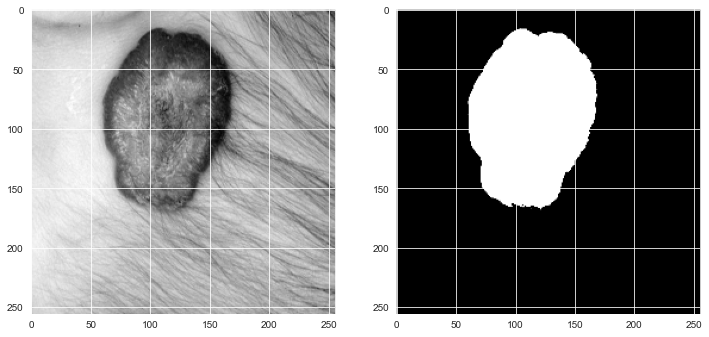

In [6]:
#Plot random images and their respective masks to make sure everything is still in order
import random
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number, :,:, 0], cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [7]:
#ImageDataGenerator where interpolation that comes with rotation and shear are thresholded in masks.
#The result will be a binary mask rather than a mask with interpolated values.
seed=12
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                        width_shift_range=0.3,
                        height_shift_range=0.3,
                        shear_range=0.5,
                        zoom_range=0.3,
                        horizontal_flip=True,
                        vertical_flip=True,
                        fill_mode='nearest')

mask_data_gen_args = dict(rotation_range=90,
                          width_shift_range=0.3,
                          height_shift_range=0.3,
                          shear_range=0.5,
                          zoom_range=0.3,
                          horizontal_flip=True,
                          vertical_flip=True,
                          fill_mode='nearest',
                          preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))
                          #Last line used to binarize the output.

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)

mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

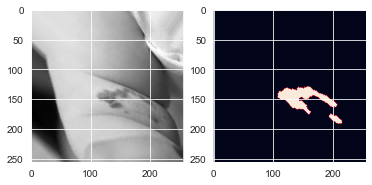

In [8]:
#Plot random images and their respective masks after using the data generator
#to make sure everything is still in order.
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [9]:
# Definining the model
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()
model = sm.Linknet(BACKBONE, encoder_weights='imagenet')
model.compile('adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   128         ['stem_conv[0][0]']              
                                32)                                                           

In [10]:
#Fitting the model
history = model.fit(my_generator,
                    validation_data=validation_datagen,
                    steps_per_epoch=20,
                    validation_steps=20,
                    epochs=30)
model.save("linknet_efficientnetb1.hdf5")
model.save("linknet_efficientnetb1.h5")

Epoch 1/30
20/20 [==============================] - 882s 43s/step - loss: 1.0586 - iou_score: 0.2878 - val_loss: 3.8267 - val_iou_score: 0.4516
Epoch 2/30
20/20 [==============================] - 773s 38s/step - loss: 0.4765 - iou_score: 0.6483 - val_loss: 24.4166 - val_iou_score: 0.2092
Epoch 3/30
20/20 [==============================] - 785s 39s/step - loss: 0.3376 - iou_score: 0.7666 - val_loss: 3.6146 - val_iou_score: 0.5164
Epoch 4/30
20/20 [==============================] - 785s 39s/step - loss: 0.2995 - iou_score: 0.7962 - val_loss: 2.9158 - val_iou_score: 0.6088
Epoch 5/30
20/20 [==============================] - 783s 39s/step - loss: 0.2599 - iou_score: 0.8239 - val_loss: 1.3283 - val_iou_score: 0.6212
Epoch 6/30
20/20 [==============================] - 770s 38s/step - loss: 0.2477 - iou_score: 0.8327 - val_loss: 0.7594 - val_iou_score: 0.6728
Epoch 7/30
20/20 [==============================] - 795s 40s/step - loss: 0.2148 - iou_score: 0.8538 - val_loss: 0.8102 - val_iou_score

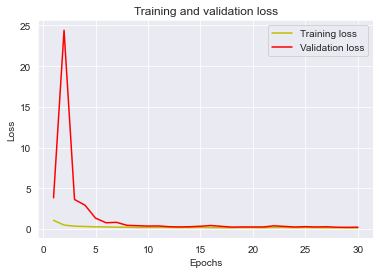

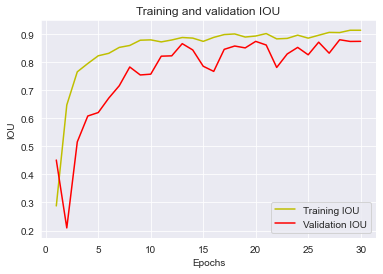

In [11]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [12]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is: ", iou_score*100,"%")

#F1 score
f1_score = 2*np.sum(intersection)/np.sum(y_pred_thresholded+y_test)
print("F1 score (recall) is: ", f1_score*100,"%")

IoU score is:  85.51405903380349 %
F1 score (recall) is:  12.471703224338379 %


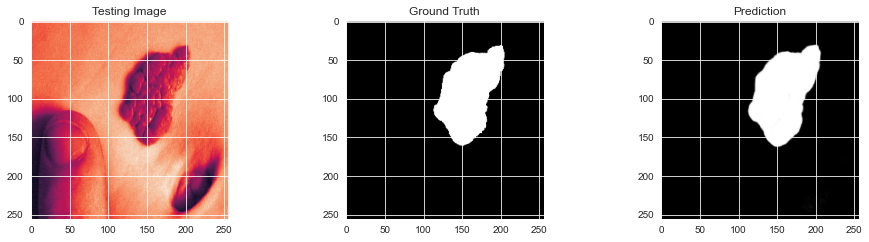

In [15]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Ground Truth')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction, cmap='gray')

plt.show()

Ground truth shape: (66, 256, 256, 1)
Prediction shape: (66, 256, 256, 1)
True positive: 12
True negative: 9278
False positive: 936
False negative: 234
Sensitivity: 0.04878048780487805
Specificity: 0.9083610730370081
False positive rate: 0.09163892696299197
False negative rate: 0.9512195121951219
Positive predictive value (Precision): 0.012658227848101266
Negative predictive value: 0.9753994953742641
False discovery rate: 0.9873417721518988
Accuracy: 0.8881453154875717


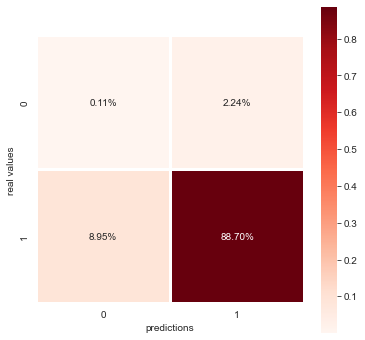

In [16]:
import seaborn as sns
ground_truth = ground_truth.reshape(256,256)
print("Ground truth shape:",y_test.shape)
print("Prediction shape:",y_pred_thresholded.shape)

y_test_arg=np.argmax(y_test,axis=1)
Y_pred = np.argmax(y_pred_thresholded,axis=1)

FP = len(np.where(Y_pred - y_test_arg  == -1)[0])
FN = len(np.where(Y_pred - y_test_arg  == 1)[0])
TP = len(np.where(Y_pred + y_test_arg ==2)[0])
TN = len(np.where(Y_pred + y_test_arg == 0)[0])
cmat = [[TP, FN], [FP, TN]]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)
# Specificity or true negative rate
TNR = TN / (TN + FP)
# Precision or positive predictive value
PPV = TP / (TP + FP)
PPV = np.where(np.isnan(PPV),0,PPV)
# Negative predictive value
NPV = TN / (TN + FN)
NPV = np.where(np.isnan(NPV), 0, NPV)
# Fall out or false positive rate
FPR = FP / (FP + TN)
FPR = np.where(np.isnan(FPR), 0, FPR)
# False negative rate
FNR = FN / (TP + FN)
FNR = np.where(np.isnan(FNR), 0, FNR)
# False discovery rate
FDR = FP / (TP + FP)
FDR = np.where(np.isnan(FDR), 0, FDR)

# Overall accuracy
ACC = (TP + TN) / (TP + FP + FN + TN)


print('True positive:', TP)
print('True negative:', TN)
print('False positive:', FP)
print('False negative:', FN)

print('Sensitivity:', TPR)
print('Specificity:', TNR)
print("False positive rate:", FPR)
print("False negative rate:", FNR)
print("Positive predictive value (Precision):", PPV)
print("Negative predictive value:", NPV)
print("False discovery rate:", FDR)
print("Accuracy:",ACC)

plt.figure(figsize = (6,6))
sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1,   linewidth=2.)
plt.xlabel("predictions")
plt.ylabel("real values")
plt.show()